In [1]:
# 1. Data Loading and Preprocessing

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
import pickle

# Load the dataset
data = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

# Convert 'TotalCharges' to numeric, setting errors='coerce' will turn invalid parsing into NaN
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')

# Handle missing values by filling numerical columns with the median
numeric_columns = data.select_dtypes(include=[np.number]).columns
data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].median())

# Drop 'customerID' since it's not useful for prediction
data.drop('customerID', axis=1, inplace=True)

# Convert categorical columns to numerical using LabelEncoder
le = LabelEncoder()
for column in data.columns:
    if data[column].dtype == 'object':
        data[column] = le.fit_transform(data[column])

# Check the first few rows to confirm changes
data.head()


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,29.85,29.85,0
1,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,3,56.95,1889.50,0
2,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,53.85,108.15,1
3,1,0,0,0,45,0,1,0,2,0,2,2,0,0,1,0,0,42.30,1840.75,0
4,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70,151.65,1


In [2]:
# 2. Train-Test Split and Feature Scaling

# Split the data into features (X) and target (y)
X = data.drop('Churn', axis=1)
y = data['Churn']

# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Check the shapes of training and test sets
X_train.shape, X_test.shape


((5634, 19), (1409, 19))

In [3]:
# 3. Model Training with Hyperparameter Tuning: Random Forest

# Use GridSearchCV to tune hyperparameters for better accuracy
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Get the best model from GridSearch
best_rf = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_rf.predict(X_test)

# Evaluate the model's accuracy
print("Best Parameters:", grid_search.best_params_)
print("Classification Report:\n", classification_report(y_test, y_pred))

# Save the trained model using Pickle
with open('best_random_forest_model.pkl', 'wb') as f:
    pickle.dump(best_rf, f)


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.91      0.88      1036
           1       0.68      0.54      0.60       373

    accuracy                           0.81      1409
   macro avg       0.76      0.72      0.74      1409
weighted avg       0.80      0.81      0.80      1409



In [4]:
# 4. Save Predictions to CSV

# Combine the test features and predicted labels into a DataFrame
predictions_df = pd.DataFrame(X_test, columns=X.columns)
predictions_df['Actual Churn'] = y_test
predictions_df['Predicted Churn'] = y_pred

# Save the predictions to a CSV file
predictions_df.to_csv('churn_predictions.csv', index=False)


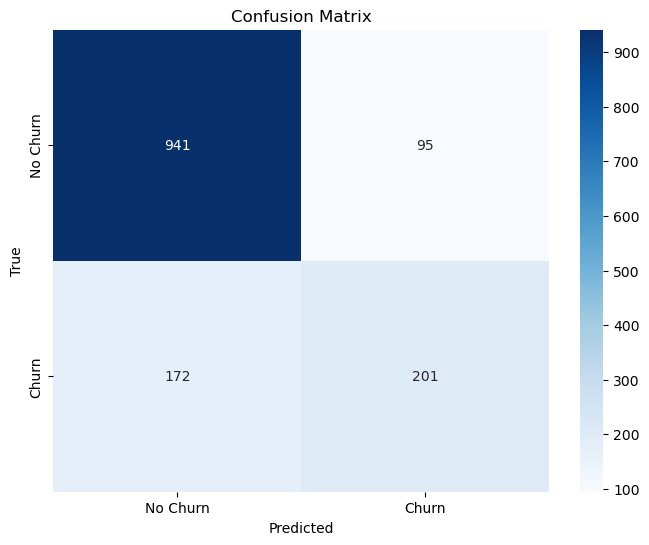

In [5]:
# 5. Model Evaluation: Confusion Matrix

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Convert the confusion matrix to a DataFrame
confusion_matrix_df = pd.DataFrame(cm, index=['No Churn', 'Churn'], columns=['Predicted No Churn', 'Predicted Churn'])

# Save the confusion matrix to a CSV file
confusion_matrix_df.to_csv('confusion_matrix.csv')

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


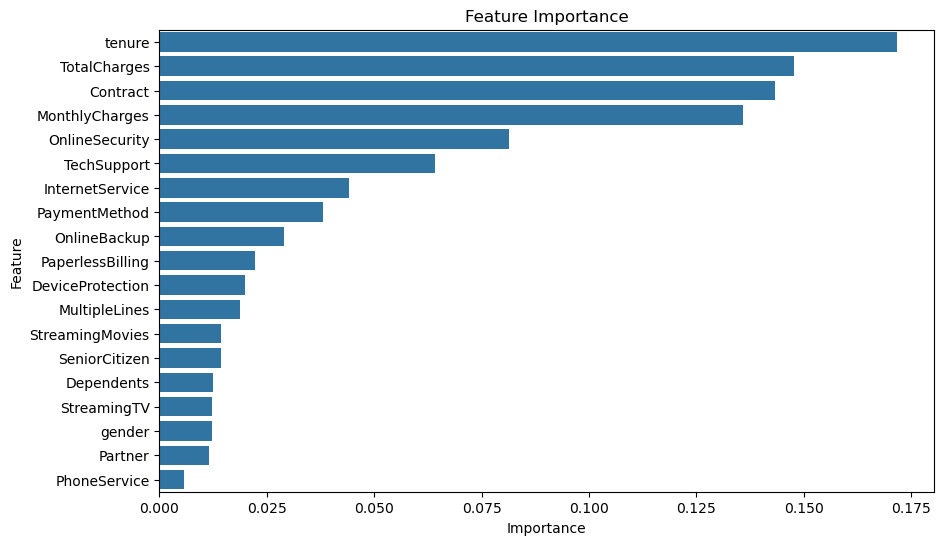

In [6]:
# 6. Feature Importance

# Get the feature importances
feature_importances = best_rf.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

# Sort the features by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Save the feature importances into a CSV file
importance_df.to_csv('feature_importances.csv', index=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance')
plt.show()


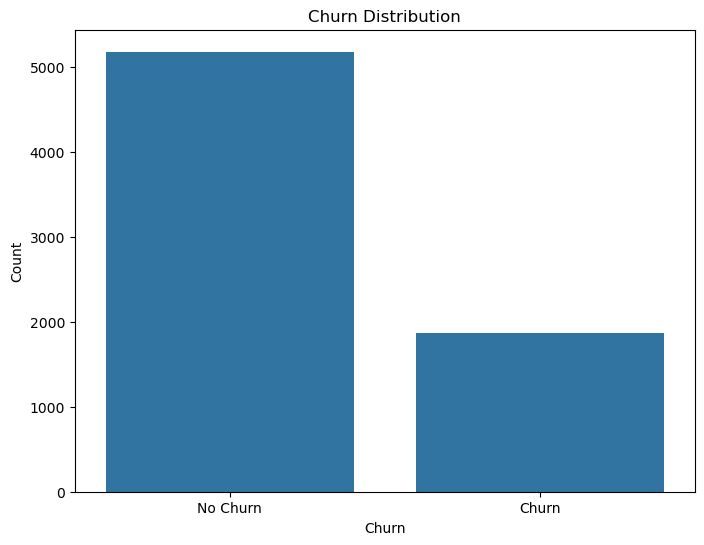

In [7]:
# 7. Churn Distribution

plt.figure(figsize=(8, 6))
sns.countplot(x='Churn', data=data)
plt.title('Churn Distribution')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.xticks([0, 1], ['No Churn', 'Churn'])
plt.show()


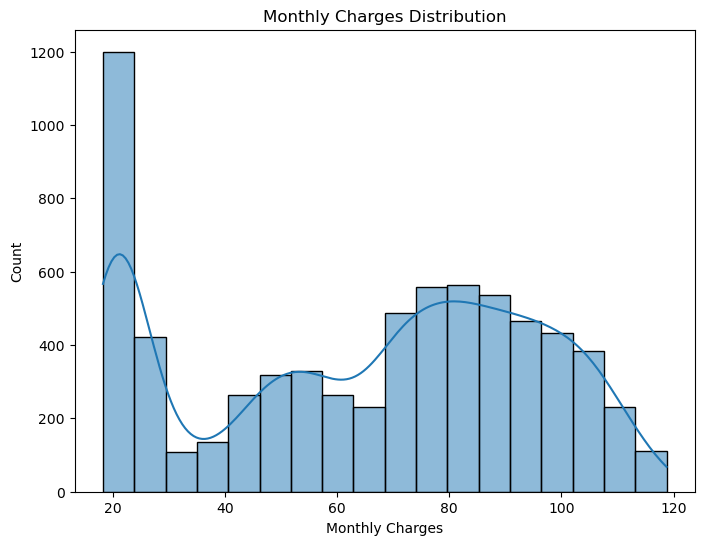

In [8]:
# 8. Monthly Charges Distribution

plt.figure(figsize=(8, 6))
sns.histplot(data['MonthlyCharges'], kde=True)
plt.title('Monthly Charges Distribution')
plt.xlabel('Monthly Charges')
plt.ylabel('Count')
plt.show()


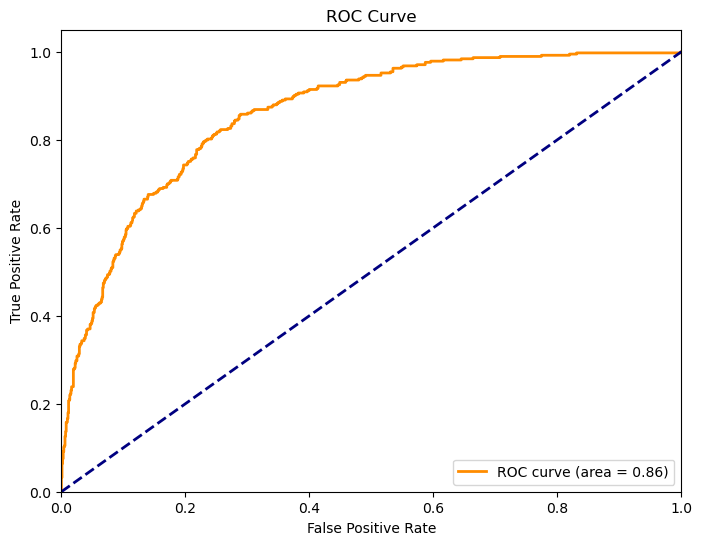

In [9]:
# 7. ROC Curve

# Calculate the predicted probabilities
y_prob = best_rf.predict_proba(X_test)[:, 1]

# Get the false positive rate and true positive rate
fpr, tpr, _ = roc_curve(y_test, y_prob)

# Calculate the Area Under the Curve (AUC)
roc_auc = auc(fpr, tpr)

# Create a DataFrame for ROC curve values
roc_df = pd.DataFrame({
    'False Positive Rate': fpr,
    'True Positive Rate': tpr
})

# Save the ROC curve data to a CSV file
roc_df.to_csv('roc_curve.csv', index=False)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


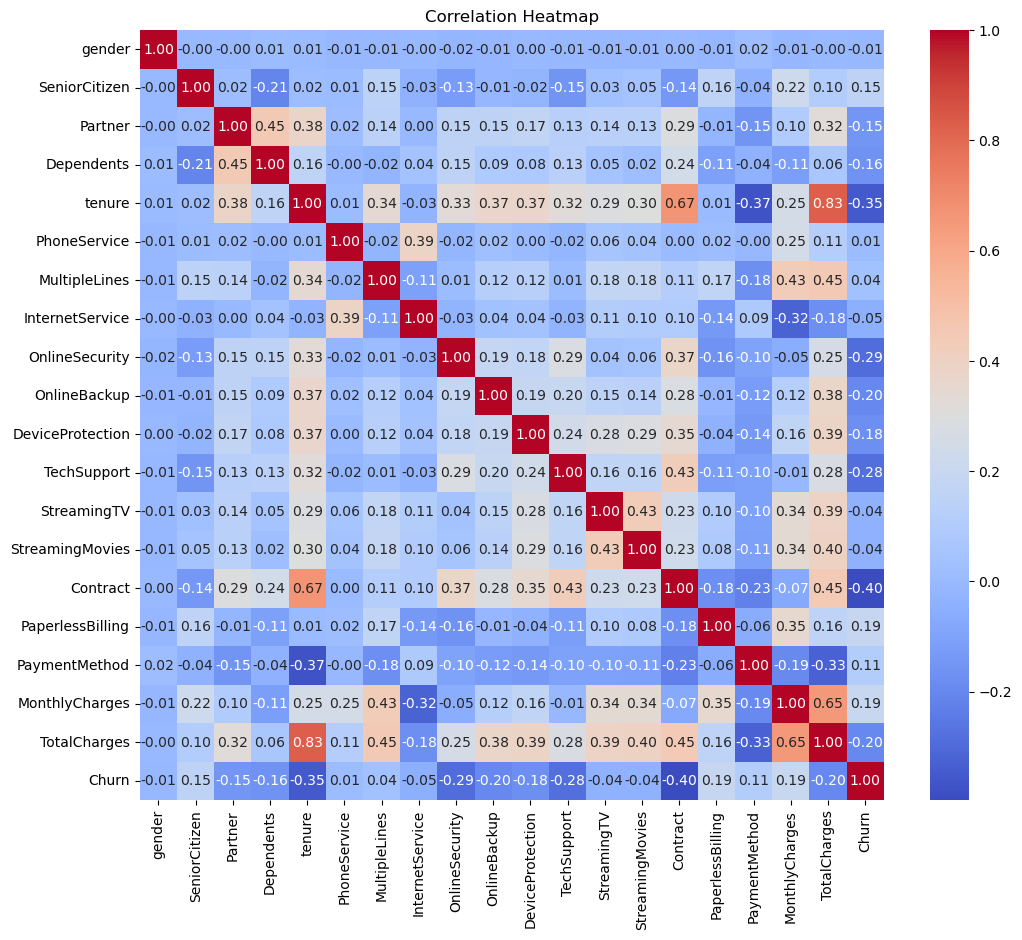

In [10]:
# 10. Correlation Heatmap

plt.figure(figsize=(12, 10))
corr_matrix = data.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()


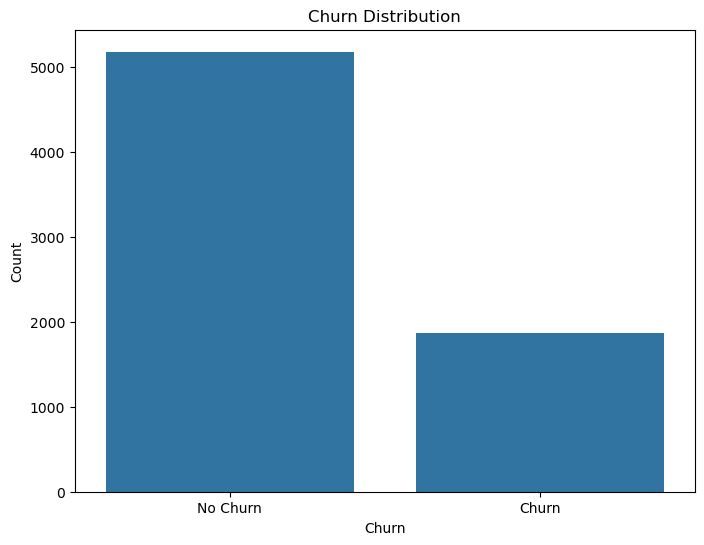

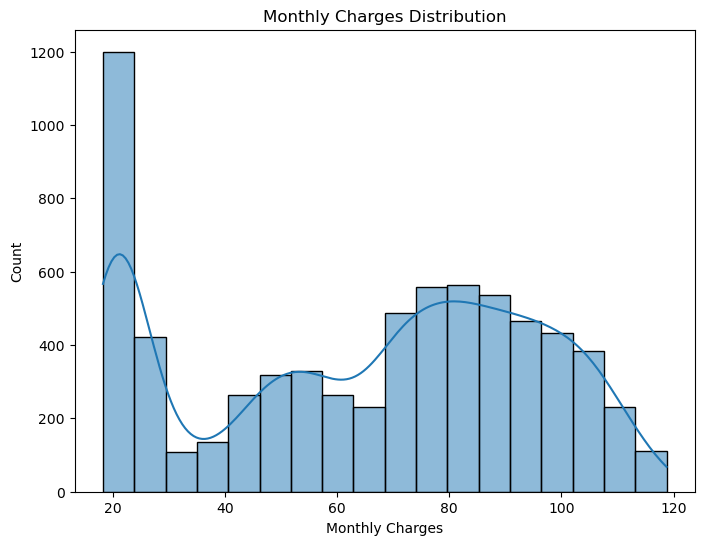

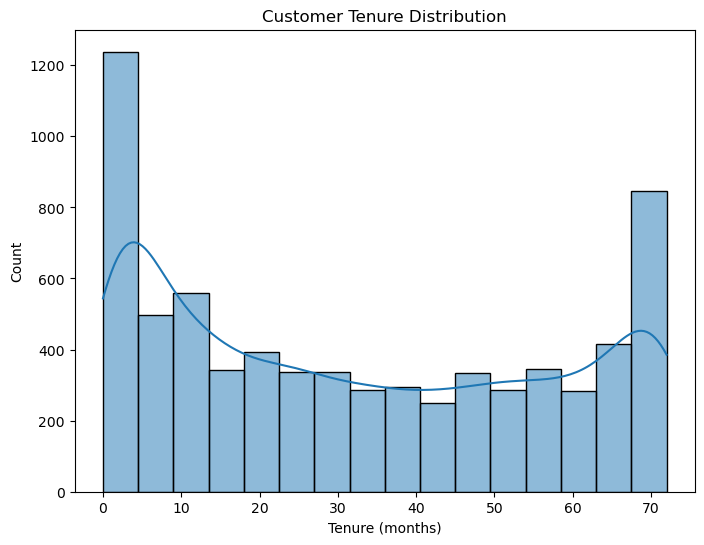

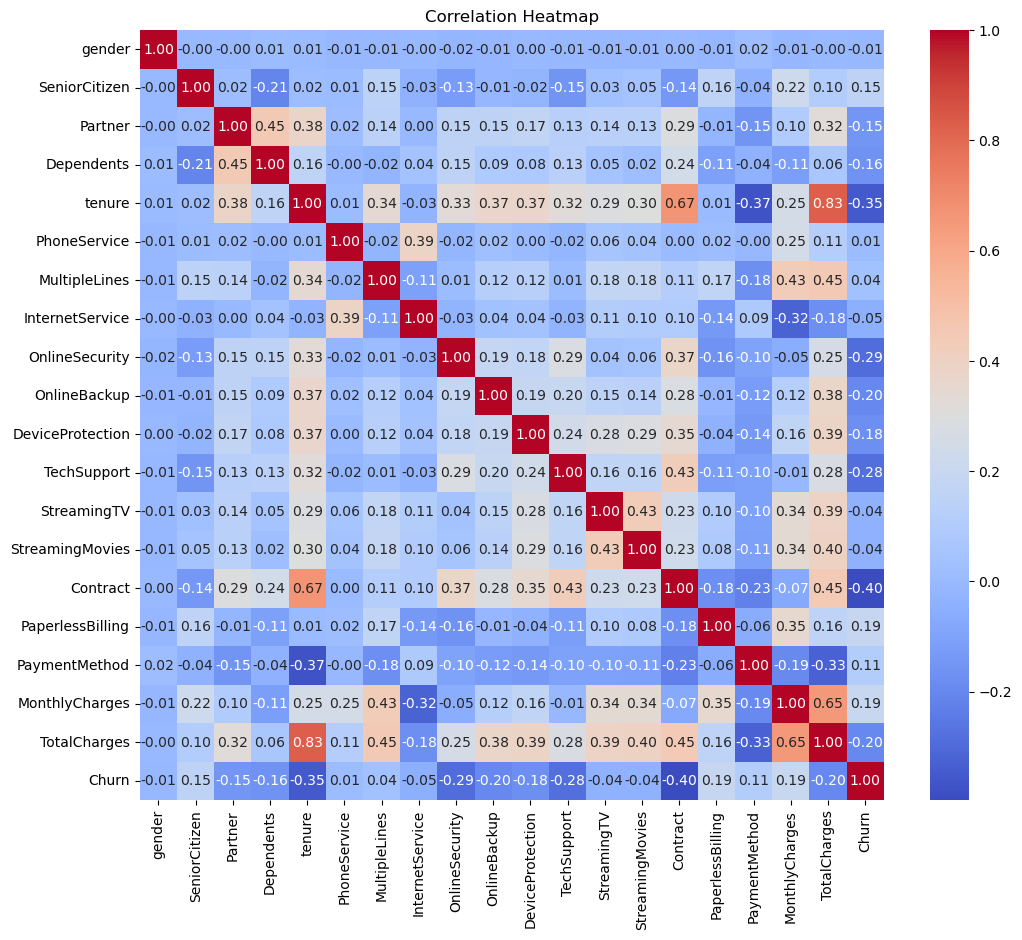

In [11]:
# 8. Churn Distribution

plt.figure(figsize=(8, 6))
sns.countplot(x='Churn', data=data)
plt.title('Churn Distribution')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.xticks([0, 1], ['No Churn', 'Churn'])
plt.show()

# 9. Monthly Charges Distribution

plt.figure(figsize=(8, 6))
sns.histplot(data['MonthlyCharges'], kde=True)
plt.title('Monthly Charges Distribution')
plt.xlabel('Monthly Charges')
plt.ylabel('Count')
plt.show()

# 10. Tenure Distribution

plt.figure(figsize=(8, 6))
sns.histplot(data['tenure'], kde=True)
plt.title('Customer Tenure Distribution')
plt.xlabel('Tenure (months)')
plt.ylabel('Count')
plt.show()

# 11. Correlation Heatmap

plt.figure(figsize=(12, 10))
corr_matrix = data.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()


In [12]:
from sklearn.metrics import accuracy_score

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)

# Print the accuracy
print(f"Model Accuracy: {accuracy * 100:.2f}%")


Model Accuracy: 81.05%
